### Análisis general del data set

##### Tamaño de las imágenes

In [5]:
import cv2

I = cv2.imread('/home/ana/TFM/datasets/desperfectos moviles.v1i.yolov9/train/images/IMG_0001-1-_png.rf.35103894e55e2ec3e3324ea4f2ff08eb.jpg')

print(f'El tamaño de la imagen es: {I.shape}, siendo su total de píxeles {I.shape[0]*I.shape[1]} píxeles')
print(f'La red neuronal tiene como tamaño de entrada 640*640, que vienen a ser {640*640} píxeles')
print(f'El porcentaje de píxeles pérdidos al reducir el tamaño de la imagen son: {100-(((640*640)/(I.shape[0]*I.shape[1]))*100)} %')


El tamaño de la imagen es: (4032, 3024, 3), siendo su total de píxeles 12192768 píxeles
La red neuronal tiene como tamaño de entrada 640*640, que vienen a ser 409600 píxeles
El porcentaje de píxeles pérdidos al reducir el tamaño de la imagen son: 96.64063156126649 %


Podemos ver que se pierde muchísima información al reducir el tamaño de la imagen y dado que los objetos que queremos de detectar (desperfectos en los móviles) tienen un tamaño muy pequeño, esto hace que con el redimensionado perdamos la posibilidad de detectarlos. **Hay que buscar una alternativa que evite tanta pérdida de información.** 

##### Balanceo de las clases

In [22]:
import os
import yaml
from collections import defaultdict

def count_labels(full_path, class_names):
    label_counts = defaultdict(int)

    # Verificar si la ruta de las imágenes es un directorio
    if os.path.isdir(full_path):
        #print(f"Explorando {full_path}...")
        # Iterar sobre cada archivo en el directorio de imágenes
        for file in os.listdir(full_path):
            # Comprobar si el archivo es un archivo de anotación txt
            if file.endswith('.txt'):
                #print(f"Leyendo {file}...")
                # Abrir y leer el archivo de anotación
                with open(os.path.join(full_path, file), 'r') as f:
                    for line in f:
                        # Extraer la clase de la anotación
                        class_id = int(line.split()[0])
                        label_counts[class_names[class_id]] += 1
    else:
        print(f"No se encontró el directorio {full_path}.")

    return label_counts


# Ruta base donde se encuentran las carpetas (ajustar según sea necesario)
yaml_path = '/home/ana/TFM/datasets/desperfectos_moviles.v1i.yolov9/data.yaml'

# Leer el archivo YAML para obtener las rutas
with open(yaml_path, 'r') as file:
    data = yaml.safe_load(file)

# Contar etiquetas para entrenamiento, validación y prueba
train_counts = count_labels('/home/ana/TFM/datasets/desperfectos_moviles.v1i.yolov9/train/labels', data['names'])
val_counts = count_labels('/home/ana/TFM/datasets/desperfectos_moviles.v1i.yolov9/valid/labels', data['names'])
test_counts = count_labels('/home/ana/TFM/datasets/desperfectos_moviles.v1i.yolov9/test/labels', data['names'])

# Imprimir los recuentos
print("Recuento de etiquetas de entrenamiento:", train_counts)
print("Recuento de etiquetas de validación:", val_counts)
print("Recuento de etiquetas de prueba:", test_counts)


Recuento de etiquetas de entrenamiento: defaultdict(<class 'int'>, {'Pantalla leve': 2811, 'Chasis profundo': 1174, 'Chasis leve': 7353, 'Camara leve': 270, 'Camara aranada': 24, 'Pantalla rota': 71, 'Pantalla profundo': 51, 'Chasis roto': 35, 'Falta bandeja sim': 4, 'Camara rota': 2})
Recuento de etiquetas de validación: defaultdict(<class 'int'>, {'Chasis leve': 1550, 'Pantalla leve': 732, 'Chasis roto': 42, 'Chasis profundo': 90, 'Pantalla profundo': 5, 'Pantalla rota': 10, 'Camara aranada': 14, 'Camara leve': 13, 'Camara rota': 1})
Recuento de etiquetas de prueba: defaultdict(<class 'int'>, {'Chasis leve': 505, 'Chasis profundo': 10, 'Pantalla leve': 174, 'Falta bandeja sim': 1, 'Camara aranada': 1, 'Camara leve': 22, 'Pantalla profundo': 3, 'Chasis roto': 18, 'Camara rota': 1})


In [27]:
# Función para imprimir el porcentaje de cada clase
def print_class_percentages(label_counts,folder):
    total_labels= sum(label_counts.values())
    print(f"\033[1mPorcentaje de cada clase en el total de etiquetas para {folder}:\033[0m")
    for class_name, count in label_counts.items():
        percentage = (count / total_labels) * 100
        print(f"{class_name}: {percentage:.2f}%")

print_class_percentages(train_counts,'train')        
print_class_percentages(val_counts,'valid')   
print_class_percentages(test_counts,'test')   

Porcentaje de cada clase en el total de etiquetas para train:
Pantalla leve: 23.83%
Chasis profundo: 9.95%
Chasis leve: 62.34%
Camara leve: 2.29%
Camara aranada: 0.20%
Pantalla rota: 0.60%
Pantalla profundo: 0.43%
Chasis roto: 0.30%
Falta bandeja sim: 0.03%
Camara rota: 0.02%
Porcentaje de cada clase en el total de etiquetas para valid:
Chasis leve: 63.09%
Pantalla leve: 29.79%
Chasis roto: 1.71%
Chasis profundo: 3.66%
Pantalla profundo: 0.20%
Pantalla rota: 0.41%
Camara aranada: 0.57%
Camara leve: 0.53%
Camara rota: 0.04%
Porcentaje de cada clase en el total de etiquetas para test:
Chasis leve: 68.71%
Chasis profundo: 1.36%
Pantalla leve: 23.67%
Falta bandeja sim: 0.14%
Camara aranada: 0.14%
Camara leve: 2.99%
Pantalla profundo: 0.41%
Chasis roto: 2.45%
Camara rota: 0.14%


In [29]:
def calculate_class_percentages(label_counts):
    total_labels = sum(label_counts.values())
    percentages = {}
    for class_name, count in label_counts.items():
        percentage = (count / total_labels) * 100
        percentages[class_name] = round(percentage, 2)  # Redondear a dos decimales
    return percentages

train_data = calculate_class_percentages(train_counts)
valid_data = calculate_class_percentages(val_counts)
test_data = calculate_class_percentages(test_counts)

In [35]:
import pandas as pd
df = pd.DataFrame({
    'Class': data['names'],
    'Train (%)': train_data.values(),
    'Valid (%)': [valid_data.get(key, 0) for key in train_data.keys()],  # Usar 0 si la clase no está en valid
    'Test (%)': [test_data.get(key, 0) for key in train_data.keys()]  # Usar 0 si la clase no está en test
})

display(df)

,Class,Train (%),Valid (%),Test (%)
0,Camara aranada,23.83,29.79,23.67
1,Camara leve,9.95,3.66,1.36
2,Camara rota,62.34,63.09,68.71
3,Chasis leve,2.29,0.53,2.99
4,Chasis profundo,0.20,0.57,0.14
5,Chasis roto,0.60,0.41,0.00
6,Falta bandeja sim,0.43,0.20,0.41
7,Pantalla leve,0.30,1.71,2.45
8,Pantalla profundo,0.03,0.00,0.14
9,Pantalla rota,0.02,0.04,0.14


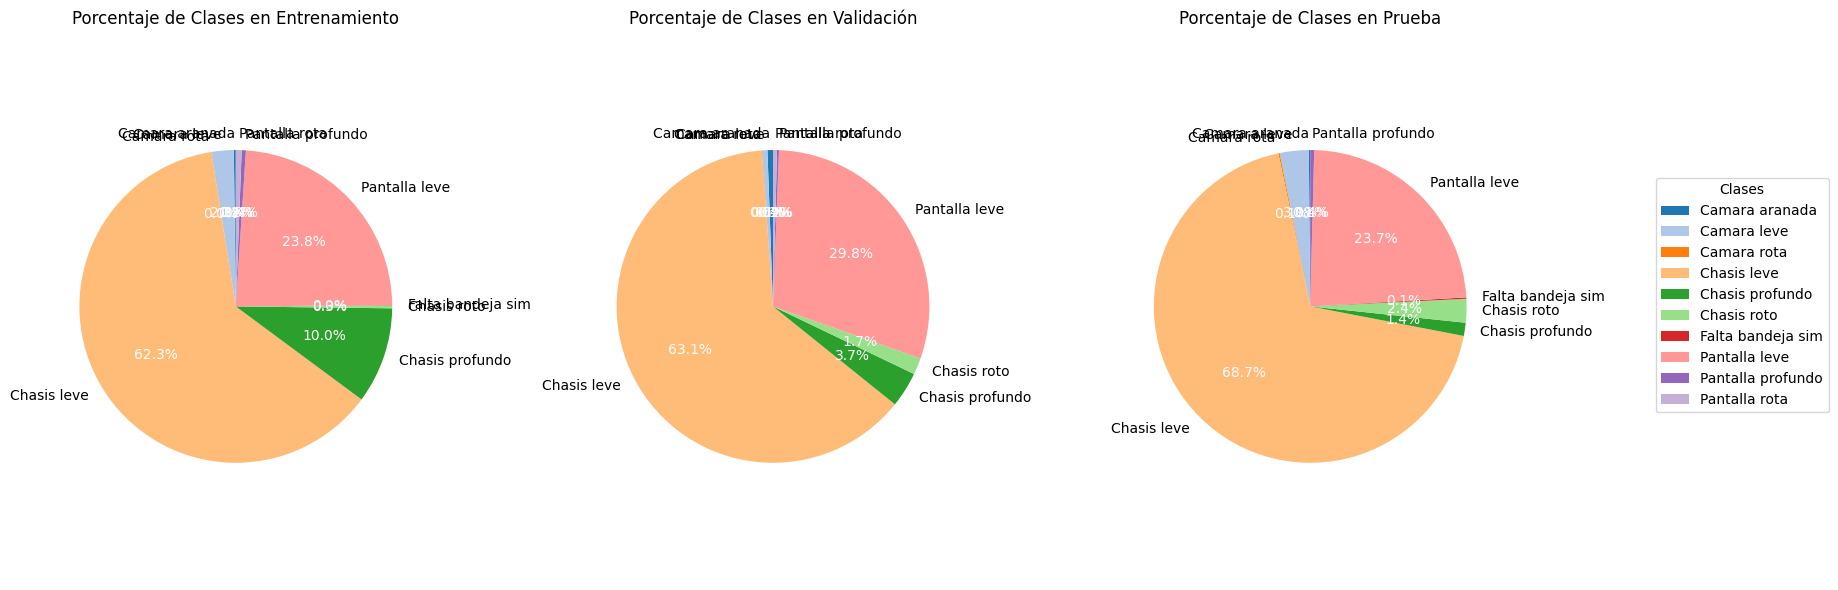

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que 'classes' y 'color_map' ya están definidos como en tus fragmentos anteriores
classes = data['names']
colors = plt.get_cmap('tab20')(range(len(classes)))  # Asegura suficientes colores
color_map = dict(zip(classes, colors))  # Asocia cada clase con un color específico

def plot_pie_chart(data, ax, title):
    # Ordenar las claves de acuerdo a la lista de clases para mantener el color consistente
    sorted_keys = sorted(data.keys(), key=lambda x: classes.index(x))
    sorted_values = [data[key] for key in sorted_keys]
    sorted_colors = [color_map[key] for key in sorted_keys]
    
    # Crear un gráfico circular en el subplot proporcionado
    wedges, texts, autotexts = ax.pie(sorted_values, labels=sorted_keys, colors=sorted_colors, autopct='%1.1f%%', startangle=90)
    for text in autotexts:
        text.set_color('white')
    
    ax.axis('equal')  # Mantiene el ratio para que el pie sea circular
    ax.set_title(title)
    
    return wedges  # Retornar los 'wedges' para usar en la leyenda

# Crear una figura y tres subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Ajusta el tamaño de la figura según sea necesario

# Dibujar los gráficos de pastel en los subplots y capturar los wedges
wedges = plot_pie_chart(train_data, axs[0], "Porcentaje de Clases en Entrenamiento")
plot_pie_chart(valid_data, axs[1], "Porcentaje de Clases en Validación")
plot_pie_chart(test_data, axs[2], "Porcentaje de Clases en Prueba")

# Crear una leyenda centralizada para los tres gráficos
fig.legend(wedges, classes, title="Clases", loc='center left', bbox_to_anchor=(0.92, 0.5), borderaxespad=0.)

# Ajustar el layout para evitar superposiciones
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ajuste para dejar espacio para la leyenda
plt.show()


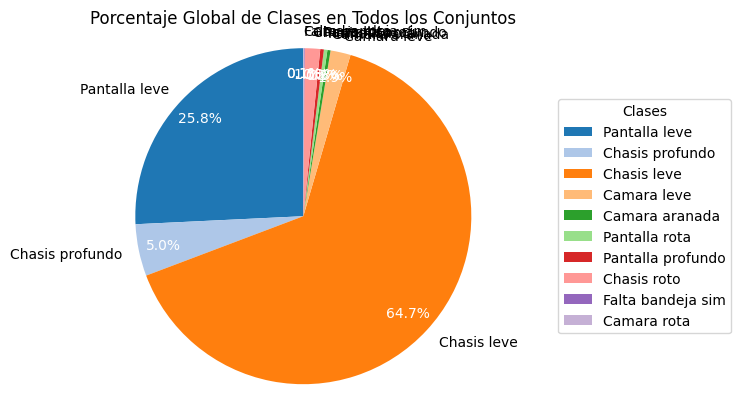

In [55]:
total_counts = defaultdict(int)

# Listas de diccionarios de recuentos para cada conjunto
datasets = [train_data, valid_data, test_data]

# Sumar las etiquetas de cada clase de todos los datasets
for dataset in datasets:
    for key, value in dataset.items():
        total_counts[key] += value

# Calcular los porcentajes globales
total_labels = sum(total_counts.values())
global_percentages = {key: (value / total_labels) * 100 for key, value in total_counts.items()}

# Datos para el gráfico
labels = list(global_percentages.keys())
sizes = list(global_percentages.values())
colors = plt.get_cmap('tab20')(range(len(labels)))  # Asegurando colores consistentes

fig, ax = plt.subplots()
# Crear el gráfico circular
wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Mejorar la legibilidad del texto automático (porcentajes)
for autotext in autotexts:
    autotext.set_color('white')

# Asegurar que se dibuje como un círculo
ax.axis('equal')

# Crear la leyenda
ax.legend(wedges, labels, title="Clases", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title('Porcentaje Global de Clases en Todos los Conjuntos')
plt.show()